In [1]:
# leaf_classification.ipynb
# ======================================
# This notebook covers the complete pipeline:
# 1) Loading and preprocessing the leaf dataset
# 2) Extracting basic features (Color Histogram + LBP)
# 3) Training and evaluating classifiers (k-NN & Decision Tree)
# 4) Visualizing results: confusion matrix and sample predictions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os                               # For file and directory operations
import cv2                              # OpenCV for image I/O and processing
import numpy as np                      # NumPy for numerical operations
import matplotlib.pyplot as plt         # Matplotlib for plotting
from skimage.feature import local_binary_pattern      # LBP texture feature
from sklearn.model_selection import train_test_split  # To split dataset
from sklearn.neighbors import KNeighborsClassifier    # k-NN classifier
from sklearn.tree import DecisionTreeClassifier       # Decision Tree classifier
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation metrics
from sklearn.preprocessing import LabelEncoder        # To encode string labels to integers

In [4]:
# 1. We firstly define dataset paths
base_dir = '/content/drive/MyDrive/archive/train/'
train_dir = os.path.join(base_dir, 'train')

In [5]:
# 2. Loading images and labels from training directory
# We'll read each class folder and process all images
def load_images_and_labels(folder):
    images = []  # list to hold image arrays
    labels = []  # list to hold corresponding class names
    # Iterate over each class subfolder
    for cls in sorted(os.listdir(folder)):
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path):
            continue  # skip files, only process directories
        # For each image file in this class folder
        for file in os.listdir(cls_path):
            if file.lower().endswith(('.jpg', '.png')):
                img_path = os.path.join(cls_path, file)
                img = cv2.imread(img_path)        # Read image in BGR format
                if img is None:
                    continue  # Skip unreadable files
                images.append(img)                # Add image to list
                labels.append(cls)                # Add class label
    return images, labels

    # Loading training data
images, labels = load_images_and_labels(train_dir)
print(f"Loaded {len(images)} images from {train_dir}.")  # Print count for confirmation

Loaded 4284 images from /content/drive/MyDrive/archive/train/train.


In [6]:
# 3. Preprocess images and extract basic features
# We'll extract:
#   a) Color Histogram (HSV, 8 bins per channel)
#   b) Local Binary Pattern (LBP) histogram

def extract_features(img):
    # a) Color Histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)           # Convert BGR to HSV
    h_hist = cv2.calcHist([hsv], [0], None, [8], [0,180])  # Hue histogram (8 bins)
    s_hist = cv2.calcHist([hsv], [1], None, [8], [0,256])  # Saturation histogram
    v_hist = cv2.calcHist([hsv], [2], None, [8], [0,256])  # Value histogram
    # Normalize histograms and flatten
    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()
    color_features = np.hstack([h_hist, s_hist, v_hist])   # Concatenate HSV histograms

    # b) Local Binary Pattern (LBP)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)           # Convert to grayscale
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    # Compute LBP histogram
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist.astype(float)
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize histogram

    # Final feature vector = [color hist | lbp hist]
    features = np.hstack([color_features, lbp_hist])
    return features

# Extracting features for all images
data = []
for img in images:
    feats = extract_features(img)
    data.append(feats)
X = np.array(data)  # Feature matrix

# Encode labels to integers
e = LabelEncoder()
y = e.fit_transform(labels)
class_names = e.classes_  # Save class order for reporting

print(f"Feature matrix shape: {X.shape}")
print(f"Labels vector shape: {y.shape}")

Feature matrix shape: (4284, 34)
Labels vector shape: (4284,)


In [7]:
# 4. Splitting into train and test sets
# Use 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 3427, Testing samples: 857


In [8]:
# 5. Training classifiers
# a) k-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# b) Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [9]:
# 6. Evaluating models
print("k-NN Classification Report:")
print(classification_report(y_test, knn_pred, target_names=class_names))
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred, target_names=class_names))

k-NN Classification Report:
                    precision    recall  f1-score   support

Alstonia Scholaris       0.78      0.80      0.79        96
             Arjun       0.72      0.85      0.78        89
              Bael       0.84      0.89      0.86        18
             Basil       0.83      0.91      0.87        32
            Chinar       0.52      0.35      0.42        46
             Gauva       0.91      0.76      0.83        94
             Jamun       0.79      0.83      0.81       107
          Jatropha       0.88      0.67      0.76        52
             Lemon       0.80      0.95      0.87        42
             Mango       0.77      0.77      0.77        73
       Pomegranate       0.90      0.90      0.90        98
  Pongamia Pinnata       0.83      0.87      0.85       110

          accuracy                           0.80       857
         macro avg       0.80      0.80      0.79       857
      weighted avg       0.80      0.80      0.80       857

Decision 

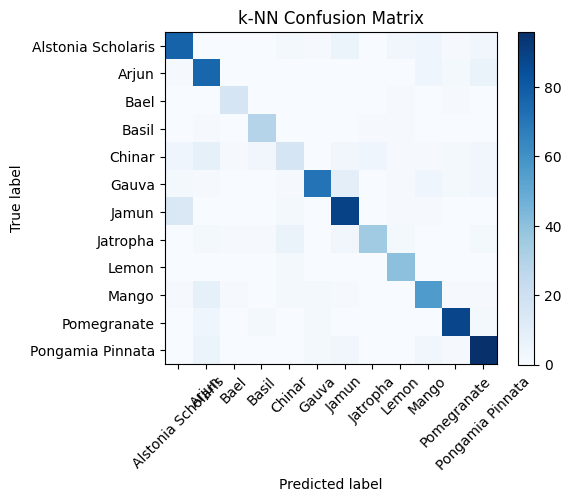

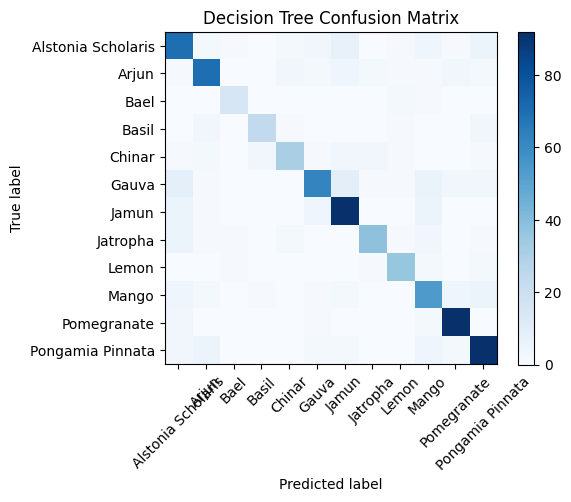

In [11]:
# 7. Plotting Confusion Matrices
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_cm(y_test, knn_pred, 'k-NN Confusion Matrix')
plot_cm(y_test, dt_pred, 'Decision Tree Confusion Matrix')

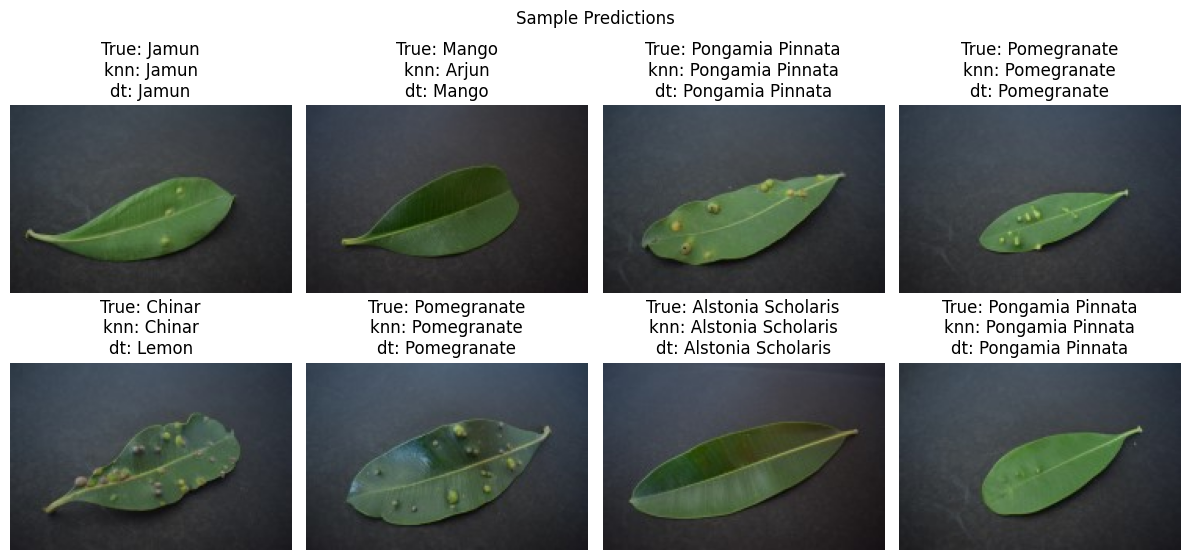

In [12]:
# 8. Visualizing sample predictions
# Display first 8 test samples with true vs predicted labels
plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    # Recover original image for display (from test indices)
    img = images[i]  # for simplicity; ideally index matches X_test
    true_label = e.inverse_transform([y_test[i]])[0]
    knn_label = e.inverse_transform([knn_pred[i]])[0]
    dt_label = e.inverse_transform([dt_pred[i]])[0]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {true_label}\nknn: {knn_label}\ndt: {dt_label}")
    plt.axis('off')
plt.suptitle('Sample Predictions')
plt.tight_layout()
plt.show()